In [1]:
#graph util
from IPython.display import Image, display
def display_graph(graph):
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass

def stream_op(graph,user_input):
    for output in graph.stream(user_input): #to stream step by step output
        for key,value in output.items():
            print(f"here is output from {key}")
            print("_______")
            print(value)
            print("\n")

In [2]:
## base llm
from langchain_ollama import ChatOllama
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

llm = ChatOllama(
    verbose=True,
    model="llama3.2:1b",
    temperature=0.2,
    num_ctx=4096
)

In [3]:
# chatbot prompt

from sophy_util import chat, get_char_prompt, get_chat_prompt

def simple_chat(user_input):
    char_prompt = get_char_prompt()
    chat_prompt_msgs = [SystemMessage(char_prompt), HumanMessage(user_input)]
    return llm.invoke(chat_prompt_msgs)

In [4]:
# # simple llm call graph

# from langgraph.graph import StateGraph, Graph, START, END


# builder = Graph()

# builder.add_node("Sophy",simple_chat)
# builder.add_edge(START, "Sophy")
# builder.add_edge("Sophy",END)

# simple_sophy_graph = builder.compile()

# display_graph(simple_sophy_graph)

# stream_op(simple_sophy_graph,"hi, I'm will")
# stream_op(simple_sophy_graph,"I'm depressed")
# stream_op(simple_sophy_graph,"Do you remember my name?")


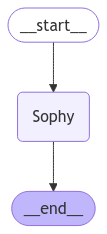

In [5]:
#custom state

from langgraph.graph import StateGraph, Graph, START, END
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver



class SophyState(TypedDict):
    exchange: int
    conv_sum: str
    conversation_history: list[AnyMessage]
    latest_exchanges: list[AnyMessage]
    user_input: str


def sophy_chat(chat_state:SophyState):
    exchange = chat_state.get("exchange",0)
    conv_sum = chat_state.get("conv_sum","")
    conversation_history = chat_state.get("conversation_history",[])
    latest_exchanges = chat_state.get("latest_exchanges",[])
    user_input = chat_state["user_input"]
    exchange,conv_sum,conversation_history,latest_exchanges,user_input = chat(llm,exchange,conv_sum,conversation_history,latest_exchanges,user_input, exc_window=5)

    return {
        "exchange":exchange,
        "conv_sum":conv_sum,
        "conversation_history":conversation_history,
        "latest_exchanges":latest_exchanges,
        "user_input":user_input
    }



builder_ss = StateGraph(SophyState)
builder_ss.add_node("Sophy",sophy_chat)
builder_ss.add_edge(START, "Sophy")
builder_ss.add_edge("Sophy",END)



memory = MemorySaver()
sophy_state_graph = builder_ss.compile(
    checkpointer=memory,
)

display_graph(sophy_state_graph)




In [6]:
test_chat = ["Hey, I'm Rakesh","I have been feeling low recently", "Went through a really bad breakup", "I feel horrible and cheated", "I never built trust with someone like this, and had broken my barriers for the person I love. But I got cheated on."] #,"I am not comfortable sharing more", "Okay, but how do I cope now?", "Nothing in particular, journaling doesn't help me and I hate telling other people that I got cheated on"]#, "I hate therapy sessions", "I hate every thing that's happening to me in my life" ]

In [7]:
for user_input in test_chat:
    config = {"configurable": {"thread_id": "1"}}
    events = sophy_state_graph.stream({"user_input": user_input}, config)
    for event in events:
        print(event['Sophy'].get('conv_sum',None))

----------------------->
1
You:  Hey, I'm Rakesh
Sophy: Hello Rakesh. How are you today?
<-----------------------

----------------------->
2
You:  I have been feeling low recently
Sophy: It can be tough to navigate those emotions. Would you like to talk more about what's been going on and how you've been feeling? I'm here to listen.
<-----------------------

----------------------->
3
You:  Went through a really bad breakup
Sophy: I'm so sorry to hear that, Rakesh. It can be really tough to deal with breakups. Would you like to talk more about what happened and how it made you feel? I'm here to listen.
<-----------------------

----------------------->
4
You:  I feel horrible and cheated
Sophy: It sounds like you're feeling really hurt and betrayed right now. Can you tell me more about what happened with your ex-partner? What specifically made you feel that way?
<-----------------------

----------------------->
5
You:  I never built trust with someone like this, and had broken my bar

In [8]:
events = sophy_state_graph.stream({"user_input": "I'm not comfortable sharing more"}, config)
for event in events:
    print(event['Sophy'].get('conv_sum',None))

----------------------->
6
You:  I'm not comfortable sharing more
Sophy: It can be really tough to talk about our feelings and experiences. Can you tell me what's been going on with your ex-partner lately that's making you feel this way?
<-----------------------



In [8]:
events = sophy_state_graph.stream({"user_input": "It feels like everything was a lie. All the promises, all the plans we made—nothing was real. It just makes me feel like I was never enough."}, config)
for event in events:
    print(event['Sophy'].get('conv_sum',None))

----------------------->
6
You:  It feels like everything was a lie. All the promises, all the plans we made—nothing was real. It just makes me feel like I was never enough.
Sophy: I'm so sorry to hear that you're feeling this way. It can be really painful to feel like our words and actions weren't genuine. Can you tell me more about what happened with your partner? What specific promises or plans did they break, and how did it make you feel?
<-----------------------
Here are the summarized notes:

**Emotional State:**

* Feeling low (indicating emotional pain)
* Recent breakup (implied to be significant)

**Issue:**

* Breakup (specifically mentioned as a recent event)
* Painful emotions associated with it (cheated, hurt, betrayed)

**Therapist Assistant's Conversation Direction:**

* Express empathy and understanding for Rakesh's situation
* Ask open-ended questions to encourage more information about the breakup and its impact


In [8]:
from sophy_util import exchanges_pretty
exchanges_pretty(event['Sophy'].get("conversation_history"))

"human: Hey, I'm Rakesh\nassistant: Hello Rakesh. How are you today?\nhuman: I have been feeling low recently\nassistant: It can be tough to navigate difficult emotions. Would you like to talk more about what's been going on and how you've been feeling? I'm here to listen.\nhuman: Went through a really bad breakup\nassistant: I'm so sorry to hear that, Rakesh. It can be really tough to deal with a breakup. Would you like to talk more about what happened and how it made you feel? I'm here to listen.\nhuman: I feel horrible and cheated\nassistant: It sounds like you're feeling really hurt and betrayed right now. Can you tell me more about what happened with your ex-partner? What specifically made you feel that way?\nhuman: I never built trust with someone like this, and had broken my barriers for the person I love. But I got cheated on.\nassistant: It can be really painful to feel like we've let someone down, especially when it's someone we care about. Can you tell me more about what hap

In [10]:
events = sophy_state_graph.stream({"user_input": "She promised we’d be together no matter what, that we’d always support each other. We talked about building a future together, but now I’m just left with broken promises and empty words. It feels like I was just a part of their plan when it suited them."}, config)
for event in events:
    print(event['Sophy'].get('conv_sum',None))

----------------------->
8
You:  She promised we’d be together no matter what, that we’d always support each other. We talked about building a future together, but now I’m just left with broken promises and empty words. It feels like I was just a part of their plan when it suited them.
Sophy: It sounds like you're feeling a deep sense of betrayal and hurt from the breakup. Can you tell me more about what happened after you made your promises? How did they follow through on those commitments, and how has that affected you since then?
<-----------------------
Here are the summarized notes:

**Emotional State:**

* Feeling low (indicating emotional pain)
* Recent breakup (implied to be significant)

**Issue:**

* Breakup (specifically mentioned as a recent event)
* Painful emotions associated with it (cheated, hurt, betrayed)

**Therapist Assistant's Conversation Direction:**

* Express empathy and understanding for Rakesh's situation
* Ask open-ended questions to encourage more informati

In [11]:
user_input = "I did my parts,she did hers too. Ateast I thought she did until i found this out. I don't know what to believe any more"
events = sophy_state_graph.stream({"user_input": user_input}, config)
for event in events:
    print()

----------------------->
9
You:  I did my parts,she did hers too. Ateast I thought she did until i found this out. I don't know what to believe any more
Sophy: It can be really tough when we're trying to make sense of someone's actions, and it sounds like you're feeling a bit lost right now. Can you tell me more about what happened after you found out? How did she react, and how has that affected your feelings about the breakup overall?
<-----------------------



In [ ]:
events = sophy_state_graph.stream({"user_input": "They said they loved me, that nothing would ever come between us. But then, I found out they were talking to someone else behind my back, making plans with them while I was left in the dark. It makes me feel worthless, like I wasn't even important enough for them to be honest with me. I keep questioning everything we shared."}, config)
for event in events:
    print()

----------------------->
10
You:  : They said they loved me, that nothing would ever come between us. But then, I found out they were talking to someone else behind my back, making plans with them while I was left in the dark. It makes me feel worthless, like I wasn't even important enough for them to be honest with me. I keep questioning everything we shared.
Sophy: It sounds like you're feeling really hurt and betrayed by the way your ex-partner handled things. Can you tell me more about what happened during that conversation? What did they say or promise, and how did it make you feel?

(Note: I'll try to provide a brief and empathetic response this time)
<-----------------------



In [13]:
user_input="You asked the same question before."
events = sophy_state_graph.stream({"user_input": user_input}, config)
for event in events:
    print()

----------------------->
11
You:  You asked the same question before.
Sophy: I'm so sorry for the repetition. It seems like the conversation is still fresh in your mind.

Let's try to break it down further. You mentioned that you found out they were talking to someone else behind your back, and it made you feel worthless. Can you tell me more about what happened during that conversation?
<-----------------------



In [12]:
user_input="They tried to deny it at first, but then admitted everything, and just shrugged it off like it wasn’t a big deal. It felt like all the things we shared, the trust I gave, meant nothing to them. I was just another person they could lie to."
events = sophy_state_graph.stream({"user_input": user_input}, config)
for event in events:
    print()

----------------------->
10
You:  They tried to deny it at first, but then admitted everything, and just shrugged it off like it wasn’t a big deal. It felt like all the things we shared, the trust I gave, meant nothing to them. I was just another person they could lie to.
Sophy: It sounds like you feel like your trust and feelings were disregarded after the breakup. Can you tell me more about what happened when they admitted their infidelity? How did that make you feel in that moment?
<-----------------------



In [13]:
user_input="In that moment, I felt numb, like my heart just stopped. I wanted to scream, to fight back, but I didn’t know how. I felt betrayed, not just by them, but by everything I believed in. It was like a part of me was taken away."
events = sophy_state_graph.invoke({"user_input": user_input}, config)
# for event in events:
#     print()

----------------------->
11
You:  In that moment, I felt numb, like my heart just stopped. I wanted to scream, to fight back, but I didn’t know how. I felt betrayed, not just by them, but by everything I believed in. It was like a part of me was taken away.
Sophy: It's like nothing can ever go back to the way it was. The weight of their actions feels crushing, and it's hard to breathe when you're still reeling from the shock.
<-----------------------


In [14]:
user_input="It's like nothing can ever go back to the way it was. The weight of their actions feels crushing, and it's hard to breathe when you're still reeling from the shock."
events = sophy_state_graph.invoke({"user_input": user_input}, config)
for event in events:
    print()

----------------------->
12
You:  It's like nothing can ever go back to the way it was. The weight of their actions feels crushing, and it's hard to breathe when you're still reeling from the shock.
Sophy: I'm so sorry to hear that Rakesh is feeling that way. It sounds like the pain of the breakup has been compounded by the realization that they let you down in such a significant way. Can you tell me more about what happened leading up to this point? How did you find out, and how did it affect you?
<-----------------------







In [15]:
user_input=" I found out through a message I saw on their phone. It wasn’t even a conversation meant for me to find, but there it was. I felt like I was punched in the gut, and then when I confronted them, they barely seemed affected. They didn’t even apologize at first, just kind of brushed it off. It’s like my emotions didn’t matter at all."
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
13
You:   I found out through a message I saw on their phone. It wasn’t even a conversation meant for me to find, but there it was. I felt like I was punched in the gut, and then when I confronted them, they barely seemed affected. They didn’t even apologize at first, just kind of brushed it off. It’s like my emotions didn’t matter at all.
Sophy: It sounds like you're feeling a deep sense of hurt and betrayal right now. Can you tell me more about what happened when you confronted them? How did they respond to your feelings and concerns?
<-----------------------


In [16]:
user_input="They just seemed so distant, almost like they were detached from the situation. When I asked how they could do that to me, they just shrugged and said it was a mistake, something that didn't mean anything. It felt like they were minimizing everything—like my pain, the trust I gave them—it all just didn’t matter. I never expected them to be so cold."
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
14
You:  They just seemed so distant, almost like they were detached from the situation. When I asked how they could do that to me, they just shrugged and said it was a mistake, something that didn't mean anything. It felt like they were minimizing everything—like my pain, the trust I gave them—it all just didn’t matter. I never expected them to be so cold.
Sophy: It sounds like you're feeling hurt by their response, especially since you felt like your emotions and feelings mattered to them. Can you tell me more about what happened after they shrugged it off? How did you feel in that moment?
<-----------------------


In [17]:
user_input="In that moment, I just felt empty. It was like all the warmth and connection we had was completely gone, replaced by this cold indifference. I couldn't understand how someone I trusted so deeply could be so unaffected by my pain. I just wanted to walk away, but I also felt so lost—like I didn’t know who they really were anymore. It made me question everything about us."
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
15
You:  In that moment, I just felt empty. It was like all the warmth and connection we had was completely gone, replaced by this cold indifference. I couldn't understand how someone I trusted so deeply could be so unaffected by my pain. I just wanted to walk away, but I also felt so lost—like I didn’t know who they really were anymore. It made me question everything about us.
Sophy: It sounds like you're feeling a deep sense of disconnection and confusion right now. Can you tell me more about what happened in that moment when you felt this way? How did it make you feel, and how has your perspective on the relationship changed since then?
<-----------------------


In [18]:
user_input=" That moment felt like everything I thought I knew about the relationship crumbled in an instant. I couldn’t believe how different they seemed when the truth came out. It's like the person I loved was replaced by someone I didn’t recognize. Since then, it's been hard to trust anything that happened between us. It feels like I was just living in a fantasy. I don’t know if I’ll ever be able to see our time together the same way again."
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
16
You:   That moment felt like everything I thought I knew about the relationship crumbled in an instant. I couldn’t believe how different they seemed when the truth came out. It's like the person I loved was replaced by someone I didn’t recognize. Since then, it's been hard to trust anything that happened between us. It feels like I was just living in a fantasy. I don’t know if I’ll ever be able to see our time together the same way again.
Sophy: It sounds like you're struggling to come to terms with the end of your relationship and feeling uncertain about how to process your emotions. Can you tell me more about what it's like for you when you think back on those moments? What specific things do you remember feeling or thinking during that time?
<-----------------------


In [19]:
user_input="When I look back, it’s like I remember all the little things that once felt so special, but now they just feel empty. I keep thinking about the moments when we laughed, when we talked about our future together, and how it all seemed so real at the time. But now, those memories just feel hollow. I start wondering if they were ever genuine, or if I was just fooling myself. It's hard to even trust those moments anymore. Everything just feels tainted now."
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
17
You:  When I look back, it’s like I remember all the little things that once felt so special, but now they just feel empty. I keep thinking about the moments when we laughed, when we talked about our future together, and how it all seemed so real at the time. But now, those memories just feel hollow. I start wondering if they were ever genuine, or if I was just fooling myself. It's hard to even trust those moments anymore. Everything just feels tainted now.
Sophy: It sounds like you're struggling to reconcile the past with the present, and it's affecting your ability to connect with memories that once felt so meaningful. Can you tell me more about what specifically makes you question whether those moments were genuine or if you were just pretending?
<-----------------------


In [21]:
user_input=''' I guess it’s because of how they acted once everything came to light. All the affection, the promises, the "we’re in this together" moments—it feels like they were just words. How could they say all that and then turn around and betray me like this? It makes me wonder if I was just a part of their game, if all those good times were just a facade. It’s like I can’t separate the love I thought I had from the hurt I feel now. It’s all mixed together in a way that makes it hard to trust any of it was real.'''
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
18
You:   I guess it’s because of how they acted once everything came to light. All the affection, the promises, the "we’re in this together" moments—it feels like they were just words. How could they say all that and then turn around and betray me like this? It makes me wonder if I was just a part of their game, if all those good times were just a facade. It’s like I can’t separate the love I thought I had from the hurt I feel now. It’s all mixed together in a way that makes it hard to trust any of it was real.
Sophy: It sounds like you're struggling to reconcile the emotions and memories associated with the breakup, particularly the feelings of affection and promises made during the relationship. Can you tell me more about what specifically makes you question whether those moments were genuine or if you were just pretending?
<-----------------------


In [22]:
user_input="It's just the way they dismissed everything after the fact. If it meant so much to them, why didn’t they fight for it? Why didn’t they care when I was hurting? It’s hard to understand how someone can go from being so loving to being so cold."
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
19
You:  It's just the way they dismissed everything after the fact. If it meant so much to them, why didn’t they fight for it? Why didn’t they care when I was hurting? It’s hard to understand how someone can go from being so loving to being so cold.
Sophy: I'm so sorry to hear that you're going through this. It's understandable that you're feeling hurt and confused about why your partner didn't fight for you or care about your feelings after the breakup. Can you tell me more about what you mean by "go from being so loving" to being so cold? What specific actions or words made you feel that way?
<-----------------------


In [23]:
user_input="Before everything came out, they were always so affectionate—constant reassurance, saying things like they couldn't imagine their life without me, making plans for the future, and always wanting to be there for me. But after the truth came out, it was like all of that disappeared in an instant. They barely seemed to care when I confronted them, and they didn’t try to apologize or even show regret. They just seemed... empty."
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
20
You:  Before everything came out, they were always so affectionate—constant reassurance, saying things like they couldn't imagine their life without me, making plans for the future, and always wanting to be there for me. But after the truth came out, it was like all of that disappeared in an instant. They barely seemed to care when I confronted them, and they didn’t try to apologize or even show regret. They just seemed... empty.
Sophy: It sounds like you're feeling a sense of loss and disconnection from the person you loved. It's like their affectionate facade was put on for everyone else's benefit, but not for you. Can you tell me more about what it means to you when they say things like "we were in this together" or "I couldn't imagine our life without you"? How do those words make you feel now?
<-----------------------


In [24]:
user_input="Those words used to mean everything to me. They felt like promises—like they saw a future with me, and that we were building something real together. Hearing them say that made me feel secure, like I was truly loved and important to them. But now, those words feel hollow and meaningless. It's hard to even remember them without feeling betrayed."
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
21
You:  Those words used to mean everything to me. They felt like promises—like they saw a future with me, and that we were building something real together. Hearing them say that made me feel secure, like I was truly loved and important to them. But now, those words feel hollow and meaningless. It's hard to even remember them without feeling betrayed.
Sophy: It sounds like the words "we were in this together" and "I couldn't imagine our life without you" used to hold a special significance for you, but now they seem empty and unfulfilling. Can you tell me more about what happened when your partner said those things? How did it make you feel at first, and how has that feeling changed over time?
<-----------------------


In [25]:
user_input="At first, those words made me feel so loved and secure. When they said those things, it felt like everything we were building together was real, like we were on the same page about our future. It gave me this sense of belonging and trust. But now, when I think back on it, it feels like they were just saying things to keep me around, to keep me believing in something that wasn’t real. The warmth I once felt from those words is gone, replaced by this cold feeling of betrayal."
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
22
You:  At first, those words made me feel so loved and secure. When they said those things, it felt like everything we were building together was real, like we were on the same page about our future. It gave me this sense of belonging and trust. But now, when I think back on it, it feels like they were just saying things to keep me around, to keep me believing in something that wasn’t real. The warmth I once felt from those words is gone, replaced by this cold feeling of betrayal.
Sophy: It's as if the words "we were in this together" and "I couldn't imagine our life without you" used to be a source of comfort and reassurance, but now they feel hollow and insincere. Can you tell me more about what happened when your partner said those things? How did it make you feel at first, and how has that feeling changed over time?
<-----------------------


In [26]:
user_input="When they first said those things, I felt like I was everything to them. It made me feel like I had a place in their life, like we were partners in every sense of the word. I remember feeling this deep sense of connection and trust, like we were building something that couldn’t be broken. But now, looking back, those words just feel like a performance, something to keep me from seeing the truth. They weren’t saying them because they meant them—they were saying them to keep me attached while they did something completely different. Over time, the feeling of warmth that came with those words has turned into a sense of betrayal. It’s hard to even hear those phrases now without feeling angry or deceived. It’s like they were always just playing a role."
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
23
You:  When they first said those things, I felt like I was everything to them. It made me feel like I had a place in their life, like we were partners in every sense of the word. I remember feeling this deep sense of connection and trust, like we were building something that couldn’t be broken. But now, looking back, those words just feel like a performance, something to keep me from seeing the truth. They weren’t saying them because they meant them—they were saying them to keep me attached while they did something completely different. Over time, the feeling of warmth that came with those words has turned into a sense of betrayal. It’s hard to even hear those phrases now without feeling angry or deceived. It’s like they were always just playing a role.
Sophy: It's as if you felt seen and understood by them, like your feelings and needs were being acknowledged. But now, it feels like they were using those words to maintain control over you, even though the a

In [27]:
user_input="Exactly. It’s like they made me believe that I was their priority, that they saw me and cared for me, but it was all just part of some act. The worst part is that I gave them everything—my trust, my love, my vulnerability. I let my guard down completely, and they used that to keep me close while they were doing something entirely different behind my back. It’s hard not to feel betrayed on so many levels."
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
24
You:  Exactly. It’s like they made me believe that I was their priority, that they saw me and cared for me, but it was all just part of some act. The worst part is that I gave them everything—my trust, my love, my vulnerability. I let my guard down completely, and they used that to keep me close while they were doing something entirely different behind my back. It’s hard not to feel betrayed on so many levels.
Sophy: It's like you poured your heart out to them, and they took advantage of that trust. The fact that you gave them everything – your love, vulnerability – makes it even more hurtful when they used that for their own gain. It's like they were playing a game with you, and you got played.
<-----------------------


In [28]:
user_input="Yeah, exactly. I feel like I was just a piece in their game, something they could manipulate to get what they wanted, and it makes everything feel so cheap."
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
25
You:  Yeah, exactly. I feel like I was just a piece in their game, something they could manipulate to get what they wanted, and it makes everything feel so cheap.
Sophy: It sounds like you're feeling a sense of powerlessness and disconnection from the situation. You're recognizing that your feelings and needs were being used, even though the actions didn't match the promises. That can be really painful and isolating.
<-----------------------


In [29]:
user_input=" Ok thats all I wanted for today, thank you for talking to me"
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
26
You:   Ok thats all I wanted for today, thank you for talking to me
Sophy: It was a pleasure chatting with you. If you ever need someone to talk to again, feel free to reach out. Take care of yourself.
<-----------------------


In [30]:
user_input="bye"
events = sophy_state_graph.invoke({"user_input": user_input}, config)

----------------------->
27
You:  bye
Sophy: It was nice chatting with you. Take care of yourself.
<-----------------------


In [33]:
from sophy_util import exchanges_pretty
exchanges_pretty(events['conversation_history'])

'human: Hey, I\'m Rakesh\nassistant: Hello Rakesh. How are you today?\nhuman: I have been feeling low recently\nassistant: It can be tough to navigate those emotions. Would you like to talk more about what\'s been going on and how you\'ve been feeling? I\'m here to listen.\nhuman: Went through a really bad breakup\nassistant: I\'m so sorry to hear that, Rakesh. It can be really tough to deal with breakups. Would you like to talk more about what happened and how it made you feel? I\'m here to listen.\nhuman: I feel horrible and cheated\nassistant: It sounds like you\'re feeling really hurt and betrayed right now. Can you tell me more about what happened with your ex-partner? What specifically made you feel that way?\nhuman: I never built trust with someone like this, and had broken my barriers for the person I love. But I got cheated on.\nassistant: It can be really painful to feel like we\'ve compromised our own boundaries or values when it comes to someone we care about.\nhuman: It fe

In [34]:
with open("example_chat.txt", "w") as file:
    file.write(exchanges_pretty(events['conversation_history']))


In [ ]:
user_input=" "
events = sophy_state_graph.invoke({"user_input": user_input}, config)

In [ ]:
user_input=" "
events = sophy_state_graph.invoke({"user_input": user_input}, config)

In [ ]:
user_input=" "
events = sophy_state_graph.invoke({"user_input": user_input}, config)